In [2]:
# Import necessary libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
file_path = '/content/drive/MyDrive/CMPE255_Assignment6/G/synthetic_book_dataset.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())
print(df)

         Genre                          Description
0  Young Adult        A young hero faces challenges
1      Mystery  A mysterious event baffles everyone
2  Non-Fiction             A deep dive into history
3     Thriller      A plot full of twists and turns
4   Historical          A story set in ancient Rome
              Genre                             Description
0       Young Adult           A young hero faces challenges
1           Mystery     A mysterious event baffles everyone
2       Non-Fiction                A deep dive into history
3          Thriller         A plot full of twists and turns
4        Historical             A story set in ancient Rome
5           Fantasy    An epic battle between good and evil
6           Fantasy              A quest in a magical realm
7          Thriller                     A suspenseful chase
8          Thriller                     A suspenseful chase
9   Science Fiction            Exploring a dystopian future
10      Non-Fiction         

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Function for preprocessing text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert to lower case
    tokens = [word.lower() for word in tokens]

    # Remove punctuation and non-alphabetic characters
    words = [word for word in tokens if word.isalpha()]

    # Filter out stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if not word in stop_words]

    return ' '.join(filtered_words)

# Apply preprocessing to the 'Description' column
df['Processed_Description'] = df['Description'].apply(preprocess_text)

# Display the first few rows of the processed dataset
print(df.head())


         Genre                          Description  \
0  Young Adult        A young hero faces challenges   
1      Mystery  A mysterious event baffles everyone   
2  Non-Fiction             A deep dive into history   
3     Thriller      A plot full of twists and turns   
4   Historical          A story set in ancient Rome   

               Processed_Description  
0        young hero faces challenges  
1  mysterious event baffles everyone  
2                  deep dive history  
3             plot full twists turns  
4             story set ancient rome  


In [4]:
!pip install transformers


In [5]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to extract embeddings
def get_embedding(text):
    # Encode text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Mean pooling for sentence representation
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Extract embeddings for the processed descriptions
df['Embedding'] = df['Processed_Description'].apply(get_embedding)

# Display the first few rows of the dataset to confirm embeddings
print(df.head())


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

         Genre                          Description  \
0  Young Adult        A young hero faces challenges   
1      Mystery  A mysterious event baffles everyone   
2  Non-Fiction             A deep dive into history   
3     Thriller      A plot full of twists and turns   
4   Historical          A story set in ancient Rome   

               Processed_Description  \
0        young hero faces challenges   
1  mysterious event baffles everyone   
2                  deep dive history   
3             plot full twists turns   
4             story set ancient rome   

                                           Embedding  
0  [-0.5135909, -0.23002012, 0.26755926, 0.006439...  
1  [0.24209929, 0.117968924, -0.14246383, -0.2395...  
2  [0.009194255, -0.035269864, -0.35069793, -0.03...  
3  [-0.30914962, -0.28457144, 0.2608733, -0.05225...  
4  [-0.06664456, 0.06745419, -0.1865046, -0.41327...  


In [9]:
from sklearn.cluster import KMeans
import numpy as np

# Extract embeddings into a numpy array for clustering
embeddings = np.stack(df['Embedding'].values)

# Number of clusters
# You can modify this number based on your dataset and needs
n_clusters = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

# Add cluster labels to the dataframe
df['Cluster'] = kmeans.labels_

# Display the first few rows to see the cluster assignments
print(df.head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         Genre                          Description  \
0  Young Adult        A young hero faces challenges   
1      Mystery  A mysterious event baffles everyone   
2  Non-Fiction             A deep dive into history   
3     Thriller      A plot full of twists and turns   
4   Historical          A story set in ancient Rome   

               Processed_Description  \
0        young hero faces challenges   
1  mysterious event baffles everyone   
2                  deep dive history   
3             plot full twists turns   
4             story set ancient rome   

                                           Embedding  Cluster  
0  [-0.5135909, -0.23002012, 0.26755926, 0.006439...        2  
1  [0.24209929, 0.117968924, -0.14246383, -0.2395...        1  
2  [0.009194255, -0.035269864, -0.35069793, -0.03...        2  
3  [-0.30914962, -0.28457144, 0.2608733, -0.05225...        1  
4  [-0.06664456, 0.06745419, -0.1865046, -0.41327...        1  


In [7]:
!pip install matplotlib scikit-learn


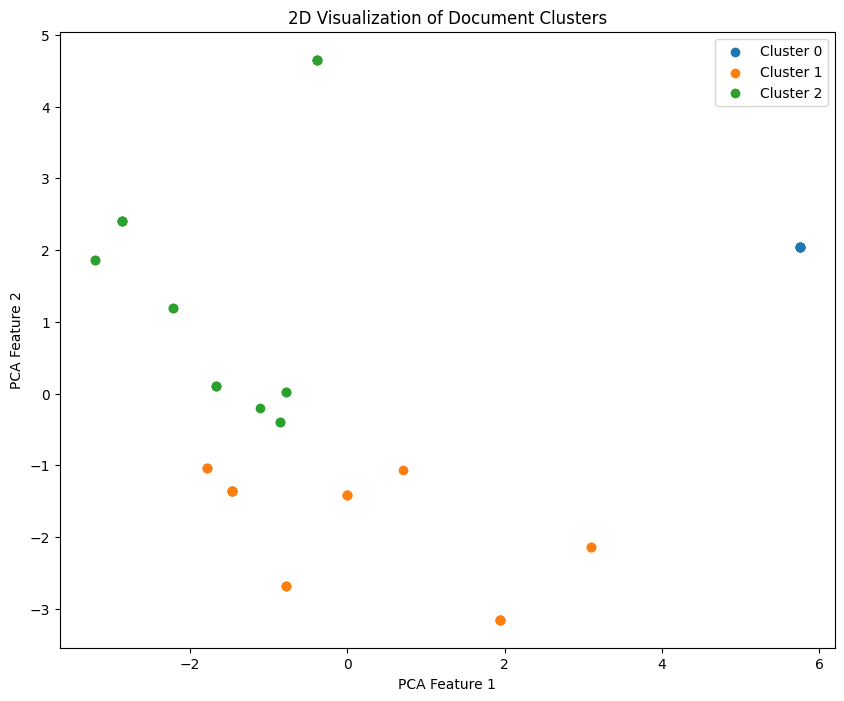

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducing the dimensionality of embeddings for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Creating a scatter plot
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    # Filter data points for each cluster
    points = reduced_embeddings[df['Cluster'] == i]

    # Plot the points with different colors
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')

# Adding labels and title
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('2D Visualization of Document Clusters')
plt.legend()

# Show the plot
plt.show()
